# Air Polution Predictive Analysis

### Deskripsi
Proyek ini dibuat untuk melakukan sebuah analisis prediktif terhadap topik polusi udara di suatu daerrah. Dengan menggunakan model regresi machine learning, berdasarkan fitur tertentu yang akan dijadikan sebagai target, lalu hasil prediksi akan menemukan nilai tertentu untuk dijadikan acuan bagaimana keadaan polusi pada bulan, minggu, hari, dan jam tertentu. Dengan hasil prediksi ini, dapat memberikan informasi kepada masyarakat tentang kapan perlu menggunakan masker dengan peringatan yang lumayan serius kepada masyarakat, ataupun himbauan untuk mengurangi kegiatan / berolahraga diluar terlebih dahulu untuk hari maupun jam tertentu. Dimana polusi udara ini masih perlu menjadi perhatian khususnya di kota-kota besar.

## 1. Import library

In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

## 2. Data Understanding

Dataset yang digunakan merupakan dataset dari kaggle dengan link di bawah ini
[PRSA_Data_Aotizhongxin 2013 - 2017](https://www.kaggle.com/datasets/shaviranurfadhilla/prsa-data-aotizhongxin-2013-2017)

### Data Loading

In [447]:
air_dataset = 'PRSA_Data_Aotizhongxin.csv'
np.random.seed(42)
total_rows = 35064
rows_to_read = 10000
rows_to_skip = np.random.choice( np.arange(1, total_rows + 1),
    size=total_rows - rows_to_read,replace=False)
main_df = pd.read_csv(air_dataset, skiprows=rows_to_skip)
main_df.sample(5)

No  year  month  day  hour  PM2.5   PM10   SO2    NO2      CO     O3  \
7680  26771  2016      3   20    10   87.0  142.0  18.0   55.0  1600.0   27.0   
8419  29420  2016      7    8    19  101.0  101.0   5.0   24.0  1000.0  222.0   
4146  14381  2014     10   21     4   32.0   32.0  17.0   58.0  1000.0    9.0   
994    3432  2013      7   21    23   59.0  147.0   6.0  109.0   800.0   19.0   
9316  32661  2016     11   20    20   17.0   17.0   2.0   28.0   600.0   31.0   

      TEMP    PRES  DEWP  RAIN   wd  WSPM       station  
7680  11.5  1024.0  -3.1   0.0   SW   0.9  Aotizhongxin  
8419  31.8  1001.3  21.0   0.0  SSW   2.0  Aotizhongxin  
4146  13.1  1018.3   0.1   0.0    S   1.3  Aotizhongxin  
994   23.7   999.9  21.8   0.0    W   0.5  Aotizhongxin  
9316   1.8  1022.4   0.8   0.1   NE   2.6  Aotizhongxin

Data yang digunakan proyek ini hanya mengambil data dengan total kolom 10000 baris dari dataset asli. Untuk lingkup percobaan sudah cukup untuk membangun model machine learning

### EDA - Deskripsi variabel

In [448]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       10000 non-null  int64  
 1   year     10000 non-null  int64  
 2   month    10000 non-null  int64  
 3   day      10000 non-null  int64  
 4   hour     10000 non-null  int64  
 5   PM2.5    9725 non-null   float64
 6   PM10     9787 non-null   float64
 7   SO2      9733 non-null   float64
 8   NO2      9692 non-null   float64
 9   CO       9479 non-null   float64
 10  O3       9527 non-null   float64
 11  TEMP     9992 non-null   float64
 12  PRES     9992 non-null   float64
 13  DEWP     9992 non-null   float64
 14  RAIN     9992 non-null   float64
 15  wd       9987 non-null   object 
 16  WSPM     9995 non-null   float64
 17  station  10000 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 1.4+ MB


Dari dataframe utama, didapatkan informasi bahwa dataset ini memiliki 18 kolom. Dengan deskripsi sebagai berikut :  
- No : Penomoran tiap baris data
- year : Tahun data tersebut
- month : Bulan data tersebut
- day : Hari data tersebut
- hour : Jam data tersebut
- PM2.5 : Particulate matter 2.5, partikel udara dengan ukuran <= 2.5 mikrometer
- PM10 : Particulate matter 10, partikel udara dengan ukuran <= 10 mikrometer
- SO2 : Sulfur dioksida, gas yang terbentuk ketika sulfur bereaksid dengan oksigen
- NO2 : Nitrogen dioksida, polutan udara yang dihasilkan bahan bakar
- CO : Karbon monoksida, terbentuk ketika bahan bakar dengan karbon dibakar tanpa cukup oksigen
- O3 : Ozon, gas yang terdiri dari 3 atom oksigen
- TEMP : Nilai temperature / suhu
- PRES : Nilai tekanan udara
- DEWP : Dew point, titik embun (nilai kelembapan udara)
- RAIN : Intensitas hujan
- wd : Wind direction, arah angin berhembus
- WSPM : Wind speed, kecepatan angin
- station : lokasi pemantauan  

Dimana fitur yang akan digunakan untuk menjadi target adalah PM2.5 yang menunjukan indikasi seberapa banyak partikel di udara yang ukurannya sangat kecil sehingga mudah mencemari udara

In [449]:
main_df.describe(include='all')

No          year         month           day          hour  \
count   10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
unique          NaN           NaN           NaN           NaN           NaN   
top             NaN           NaN           NaN           NaN           NaN   
freq            NaN           NaN           NaN           NaN           NaN   
mean    17446.54880   2014.653300      6.512900     15.830200     11.528800   
std     10117.53223      1.178575      3.444506      8.728298      6.921066   
min         2.00000   2013.000000      1.000000      1.000000      0.000000   
25%      8705.25000   2014.000000      4.000000      8.000000      6.000000   
50%     17397.50000   2015.000000      7.000000     16.000000     12.000000   
75%     26118.75000   2016.000000     10.000000     23.000000     18.000000   
max     35056.00000   2017.000000     12.000000     31.000000     23.000000   

              PM2.5         PM10          SO2          NO2            CO  \
count   9725.000000  9787.000000  9733.000000  9692.000000   9479.000000   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean      83.035033   111.092419    17.290031    59.481148   1258.065935   
std       82.366190    96.433035    22.506759    37.327050   1230.860820   
min        3.000000     3.000000     0.285600     2.000000    100.000000   
25%       22.000000    38.000000     3.000000    30.000000    500.000000   
50%       58.000000    87.000000     9.000000    54.000000    800.000000   
75%      114.000000   155.000000    21.000000    82.000000   1500.000000   
max      713.000000   948.000000   197.000000   285.000000  10000.000000   

                 O3         TEMP         PRES         DEWP         RAIN    wd  \
count   9527.000000  9992.000000  9992.000000  9992.000000  9992.000000  9987   
unique          NaN          NaN          NaN          NaN          NaN    16   
top             NaN          NaN          NaN          NaN          NaN    NE   
freq            NaN          NaN          NaN          NaN          NaN  1456   
mean      56.853931    13.552999  1011.870608     3.173629     0.070156   NaN   
std       59.024179    11.387341    10.447998    13.628126     1.101825   NaN   
min        0.214200   -16.800000   987.500000   -35.100000     0.000000   NaN   
25%        8.000000     3.100000  1003.200000    -8.000000     0.000000   NaN   
50%       42.000000    14.500000  1011.400000     3.900000     0.000000   NaN   
75%       83.000000    23.100000  1020.100000    15.700000     0.000000   NaN   
max      365.000000    40.300000  1042.000000    27.800000    72.500000   NaN   

               WSPM       station  
count   9995.000000         10000  
unique          NaN             1  
top             NaN  Aotizhongxin  
freq            NaN         10000  
mean       1.704812           NaN  
std        1.216114           NaN  
min        0.000000           NaN  
25%        0.900000           NaN  
50%        1.400000           NaN  
75%        2.200000           NaN  
max       11.200000           NaN

Didapatkan macam macam parameter data numerik maupun kategorikal berdasarkan output di atas

In [450]:
main_df.drop(["No", "station"],axis=1,inplace=True)

Karena kolom 'No' dan 'station' tidak relevan untuk digunakan pada model machine learning, maka dilakukan drop kolom tersebut

In [451]:
main_df[main_df['RAIN'] == 0.0].value_counts().sum()

np.int64(8705)

Di lain sisi, ada kolom RAIN yang memiliki nilai 0.0 dengan dominasi sangat tinggi. Maka dari itu bisa dibilang kolom RAIN ini tidak memiliki pengaruh yang signifikan terhadap keseluruhan data, sehingga dapat di drop saja

In [452]:
main_df.drop("RAIN", axis=1, inplace=True)

### EDA - Missing values

##### Missing values

In [453]:
missing_val = main_df.isnull().sum()
print(missing_val.sum())
print(missing_val)

2099
year       0
month      0
day        0
hour       0
PM2.5    275
PM10     213
SO2      267
NO2      308
CO       521
O3       473
TEMP       8
PRES       8
DEWP       8
wd        13
WSPM       5
dtype: int64


Dari pengecekan missing values, didapatkan 2099 missing values pada data. Lalu kolom dengan missing values yang cukup banyak adalah O3, CO, NO2, SO2, PM10, dan PM2.5

In [454]:
main_df['CO'] = main_df['CO'].fillna(main_df['CO'].mean())
main_df['O3'] = main_df['O3'].fillna(main_df['O3'].mean())
main_df['NO2'] = main_df['NO2'].fillna(main_df['NO2'].mean())
main_df['SO2'] = main_df['SO2'].fillna(main_df['SO2'].mean())
main_df['PM10'] = main_df['PM10'].fillna(main_df['PM10'].mean())
main_df['PM2.5'] = main_df['PM2.5'].fillna(main_df['PM2.5'].mean())
main_df.isnull().sum().sum()

np.int64(42)

Setelah dilakukan imutasi dengan menggunakan mean pada kolom yang memiliki cukup banyak missing values, keseluruhan missing values menjadi 42. Ini dapat didrop saja karena tidak terlalu berpengaruh

In [455]:
main_df.dropna(inplace=True)
main_df.isnull().sum().sum()

np.int64(0)

##### Duplicated

In [456]:
print(main_df.duplicated().sum())

0


Dari pengecekan duplikasi data, terlihat hasil menunjukan 0 yang berarti tidak ada data yang terduplikasi

##### Outliers

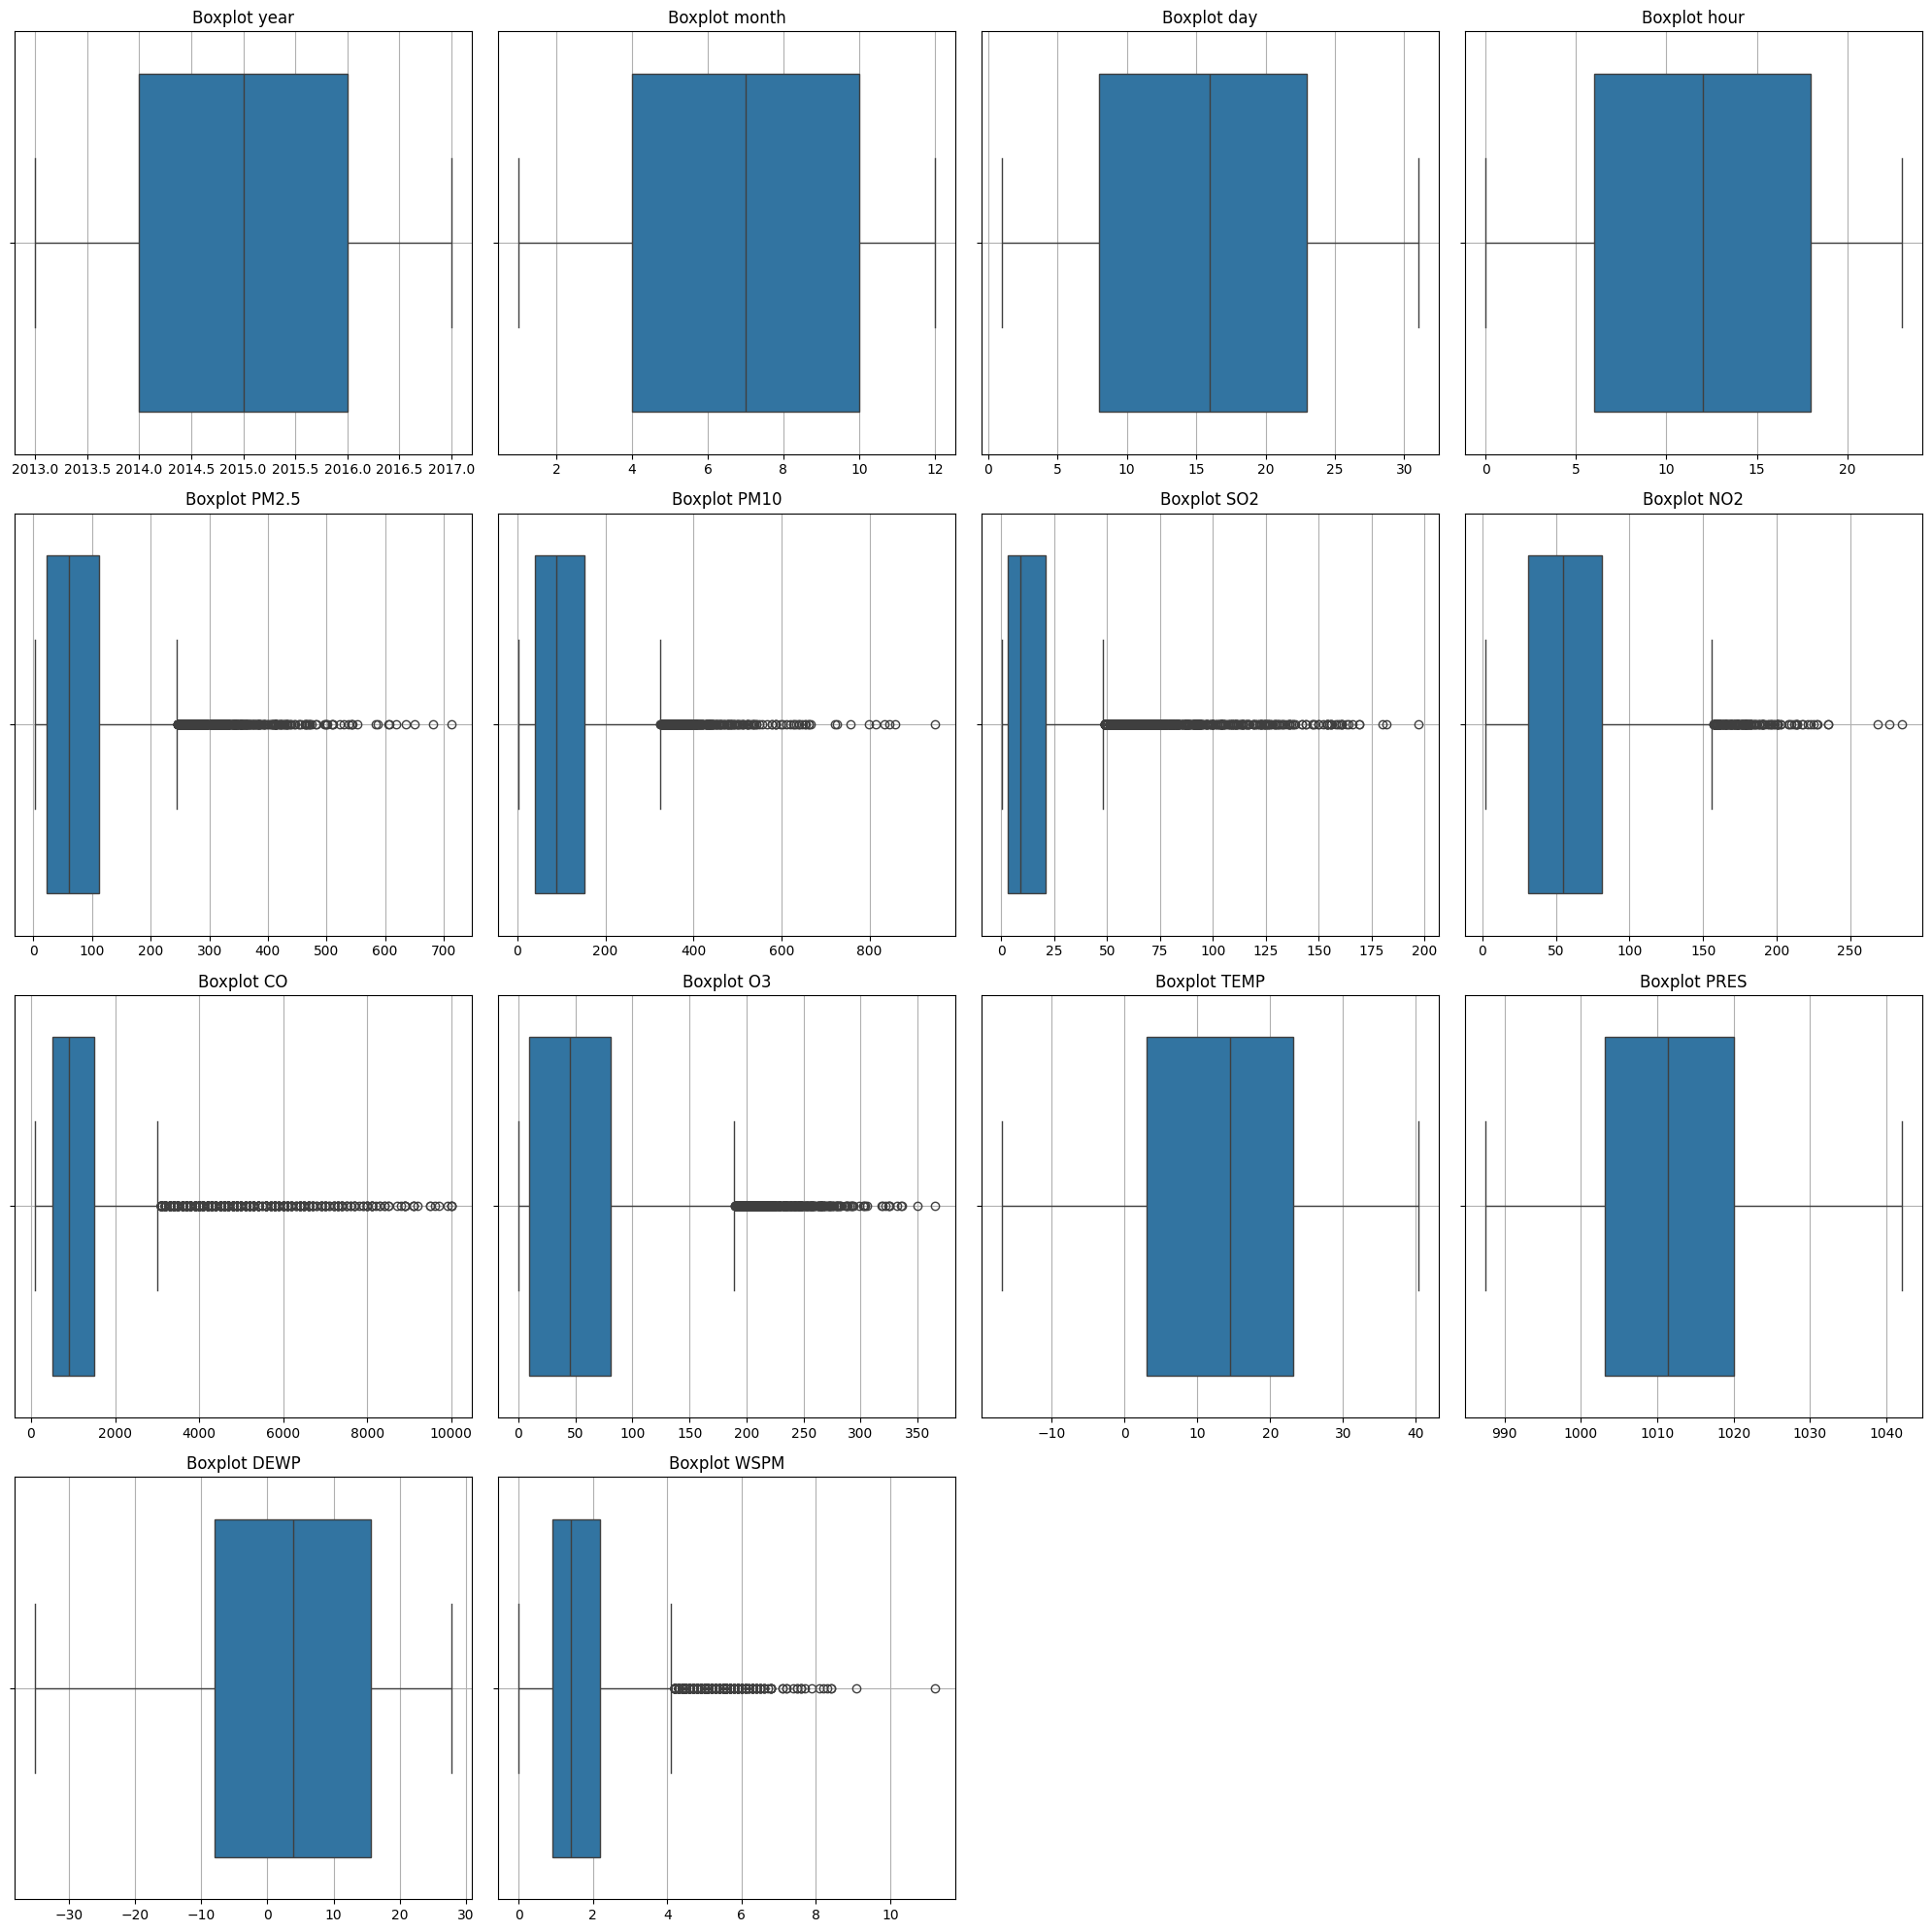

In [457]:
num_cols = main_df.select_dtypes(include='number').columns
fig, axes = plt.subplots(4, int(np.ceil(len(num_cols) / 4)), figsize=(4 * 5, 4 * 5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x=main_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')
    axes[i].set_xlabel('')
    axes[i].grid(True)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Dari hasil pengecekan outlier di atas, terlihat beberapa kolom memiliki cukup banyak dan diantaranya ada outlier yang cukup jauh seperti kolom PM2.5, PM10, SO2, NO2, RIN, O3, dan CO

In [458]:
Q1 = main_df[num_cols].quantile(0.25)
Q3 = main_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
filter_outliers = ~((main_df[num_cols] < (Q1 - 1.5 * IQR)) |
                    (main_df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
main_df = main_df[filter_outliers]
main_df.shape

(7536, 15)

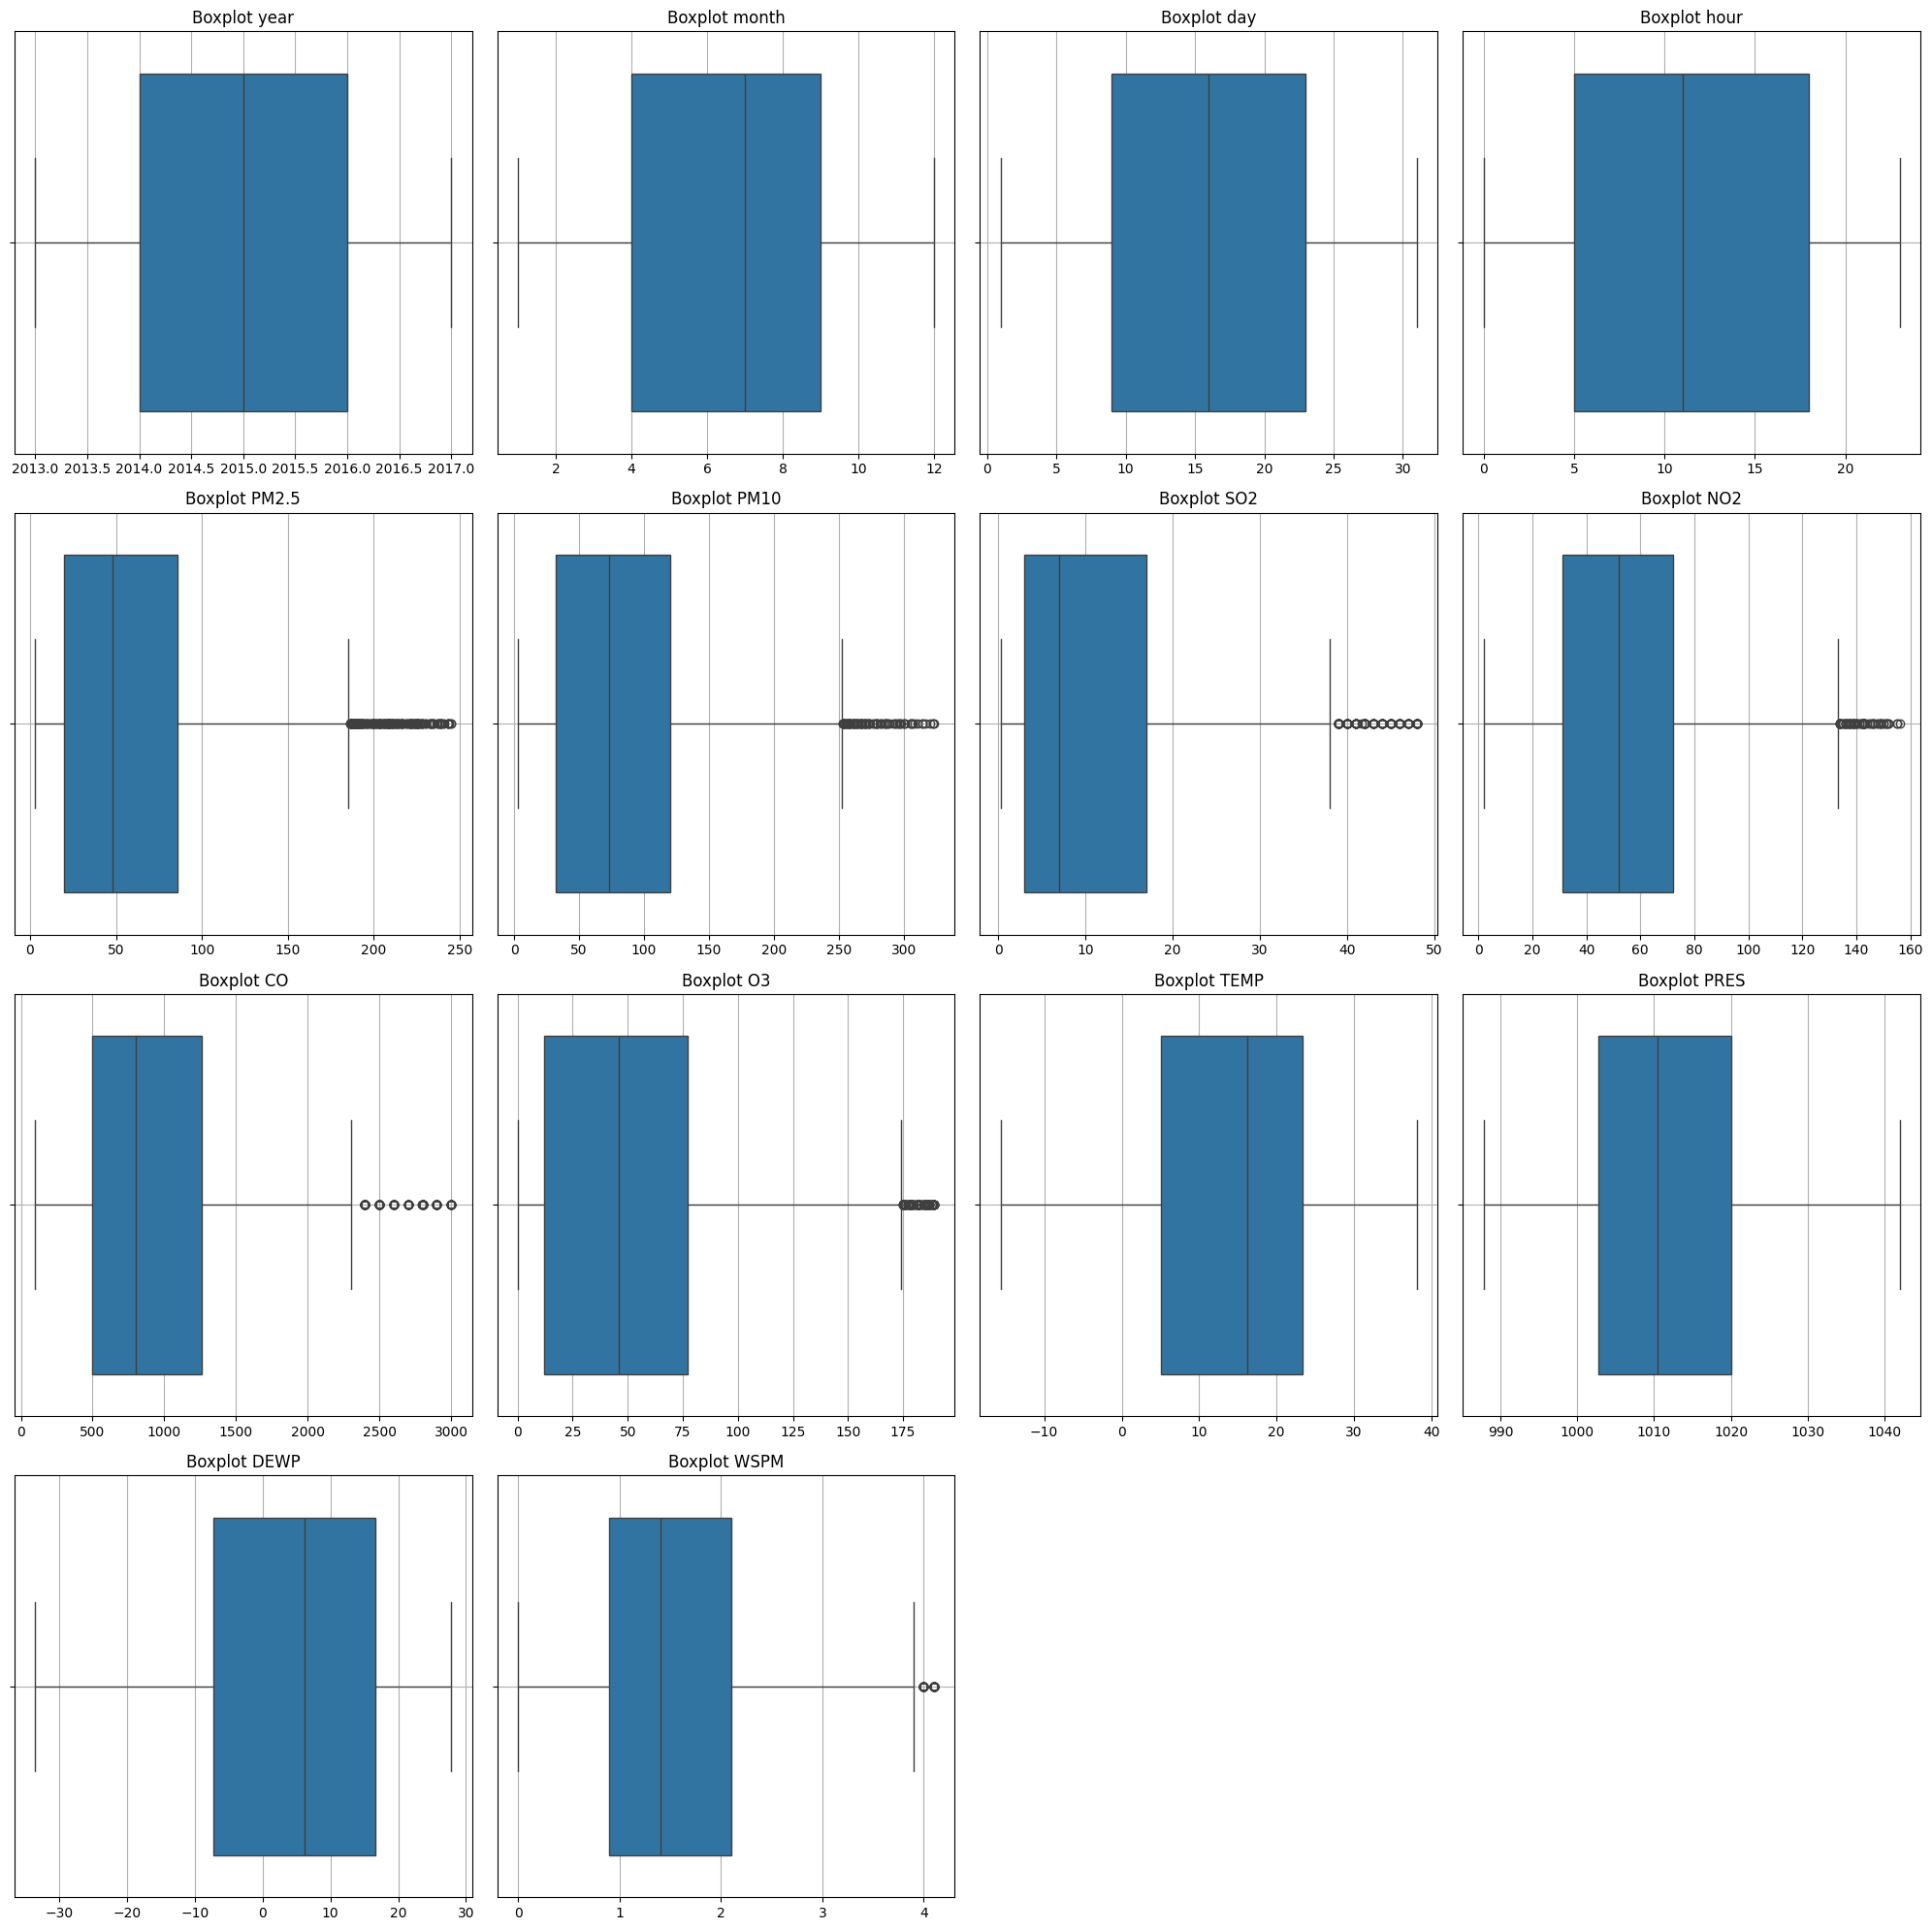

In [459]:
num_cols = main_df.select_dtypes(include='number').columns
fig, axes = plt.subplots(4, int(np.ceil(len(num_cols) / 4)), figsize=(4 * 5, 4 * 5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x=main_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')
    axes[i].set_xlabel('')
    axes[i].grid(True)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Hasil dari penghapusan baris yang mengandung outlier menjadikan total keseluruhan baris pada dataset menjadi 7536 baris

### EDA - Univariate analysis

In [460]:
cat_cols = main_df.select_dtypes(include='object').columns

     jumlah sampel  persentase
wd                            
NE            1112        14.8
ENE            828        11.0
SW             691         9.2
NNE            578         7.7
E              551         7.3
WSW            500         6.6
N              471         6.2
SSW            459         6.1
NW             395         5.2
ESE            368         4.9
NNW            310         4.1
SE             307         4.1
S              270         3.6
W              249         3.3
WNW            234         3.1
SSE            213         2.8


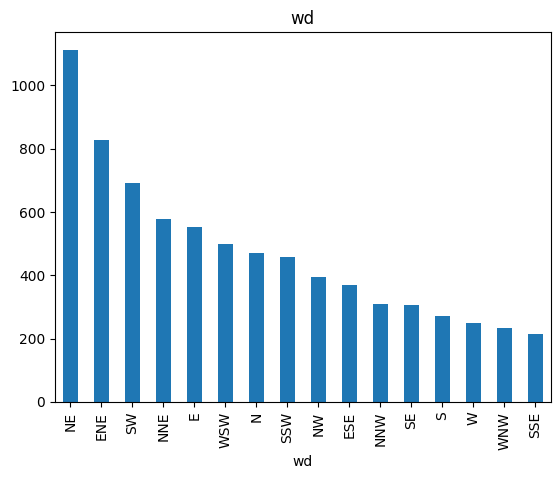

In [461]:
cat_feat = cat_cols[0]
count_cat_feat = main_df[cat_feat].value_counts()
percent_cat_feat = 100*main_df[cat_feat].value_counts(normalize=True)
cat_df = pd.DataFrame({'jumlah sampel':count_cat_feat, 'persentase':percent_cat_feat.round(1)})
print(cat_df)
count_cat_feat.plot(kind='bar', title=cat_feat);

Univariate analysis pada kategorikal fitur yaitu kolom 'wd' memperlihatkan distribusi right skewed untuk kolom tersebut. Dimana ws / arah angin 3 terbanyak didominasi oleh NE (North East), ENE (East-Northeast), dan SW (South-West)

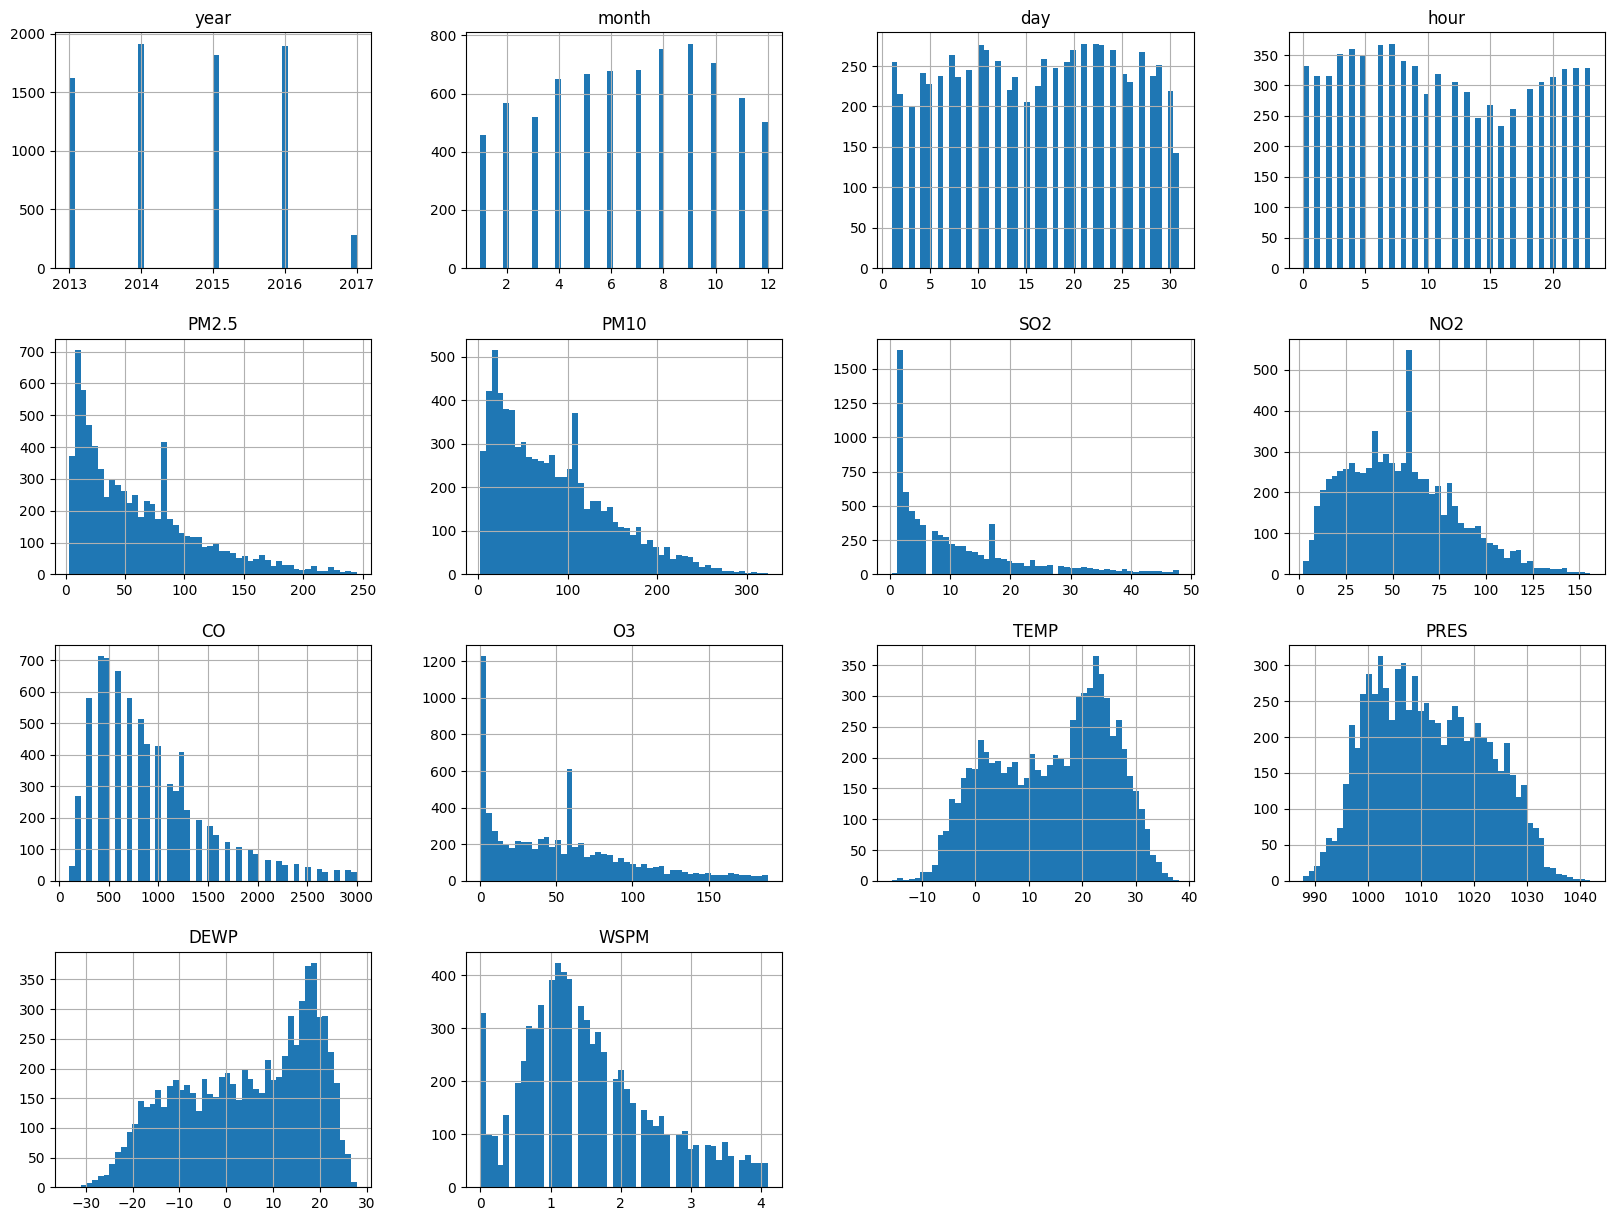

In [462]:
main_df.hist(bins=50, figsize=(20,15))
plt.show()

Untuk distribusi data dari numerikal fitur menunjukan mayoritas fitur memiliki distribusi right skewed, lalu beberapa lainnya berdistribusi acak dan mendekati normal, lalu yang paling sedikit adalah distribusi left skewed.

### EDA - Multivariate analysis

C:\Users\rahma\AppData\Local\Temp\ipykernel_4544\1248419636.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="PM2.5", kind="bar", dodge=False, height = 4, aspect = 3,  data=main_df, palette="Set3")


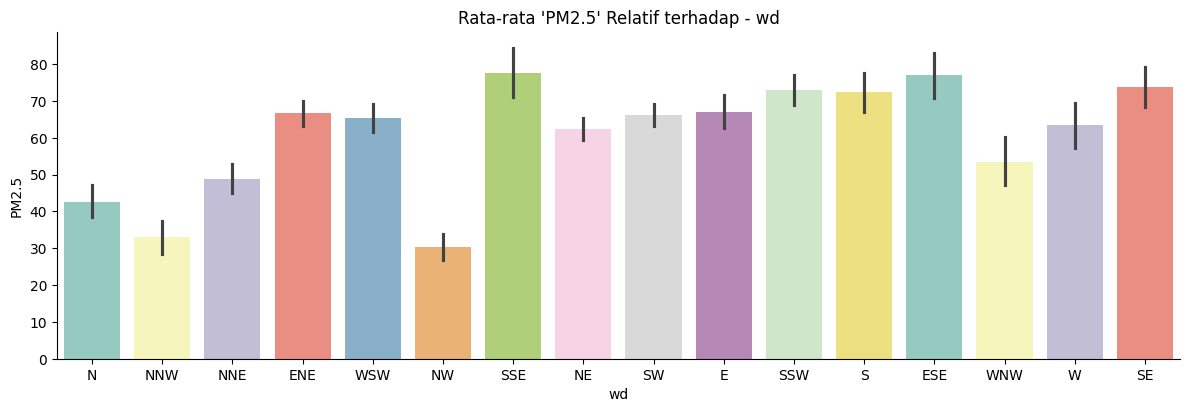

In [463]:
cat_feat_list = cat_cols.to_list()

for col in cat_feat_list:
  sns.catplot(x=col, y="PM2.5", kind="bar", dodge=False, height = 4, aspect = 3,  data=main_df, palette="Set3")
  plt.title("Rata-rata 'PM2.5' Relatif terhadap - {}".format(col))

Untuk multivariate analysis pada kategorikal fitur yaitu kolom 'wd' menunjukan relasi pada PM2.5 didominasi oleh nilai SSE, ESE, dan SE

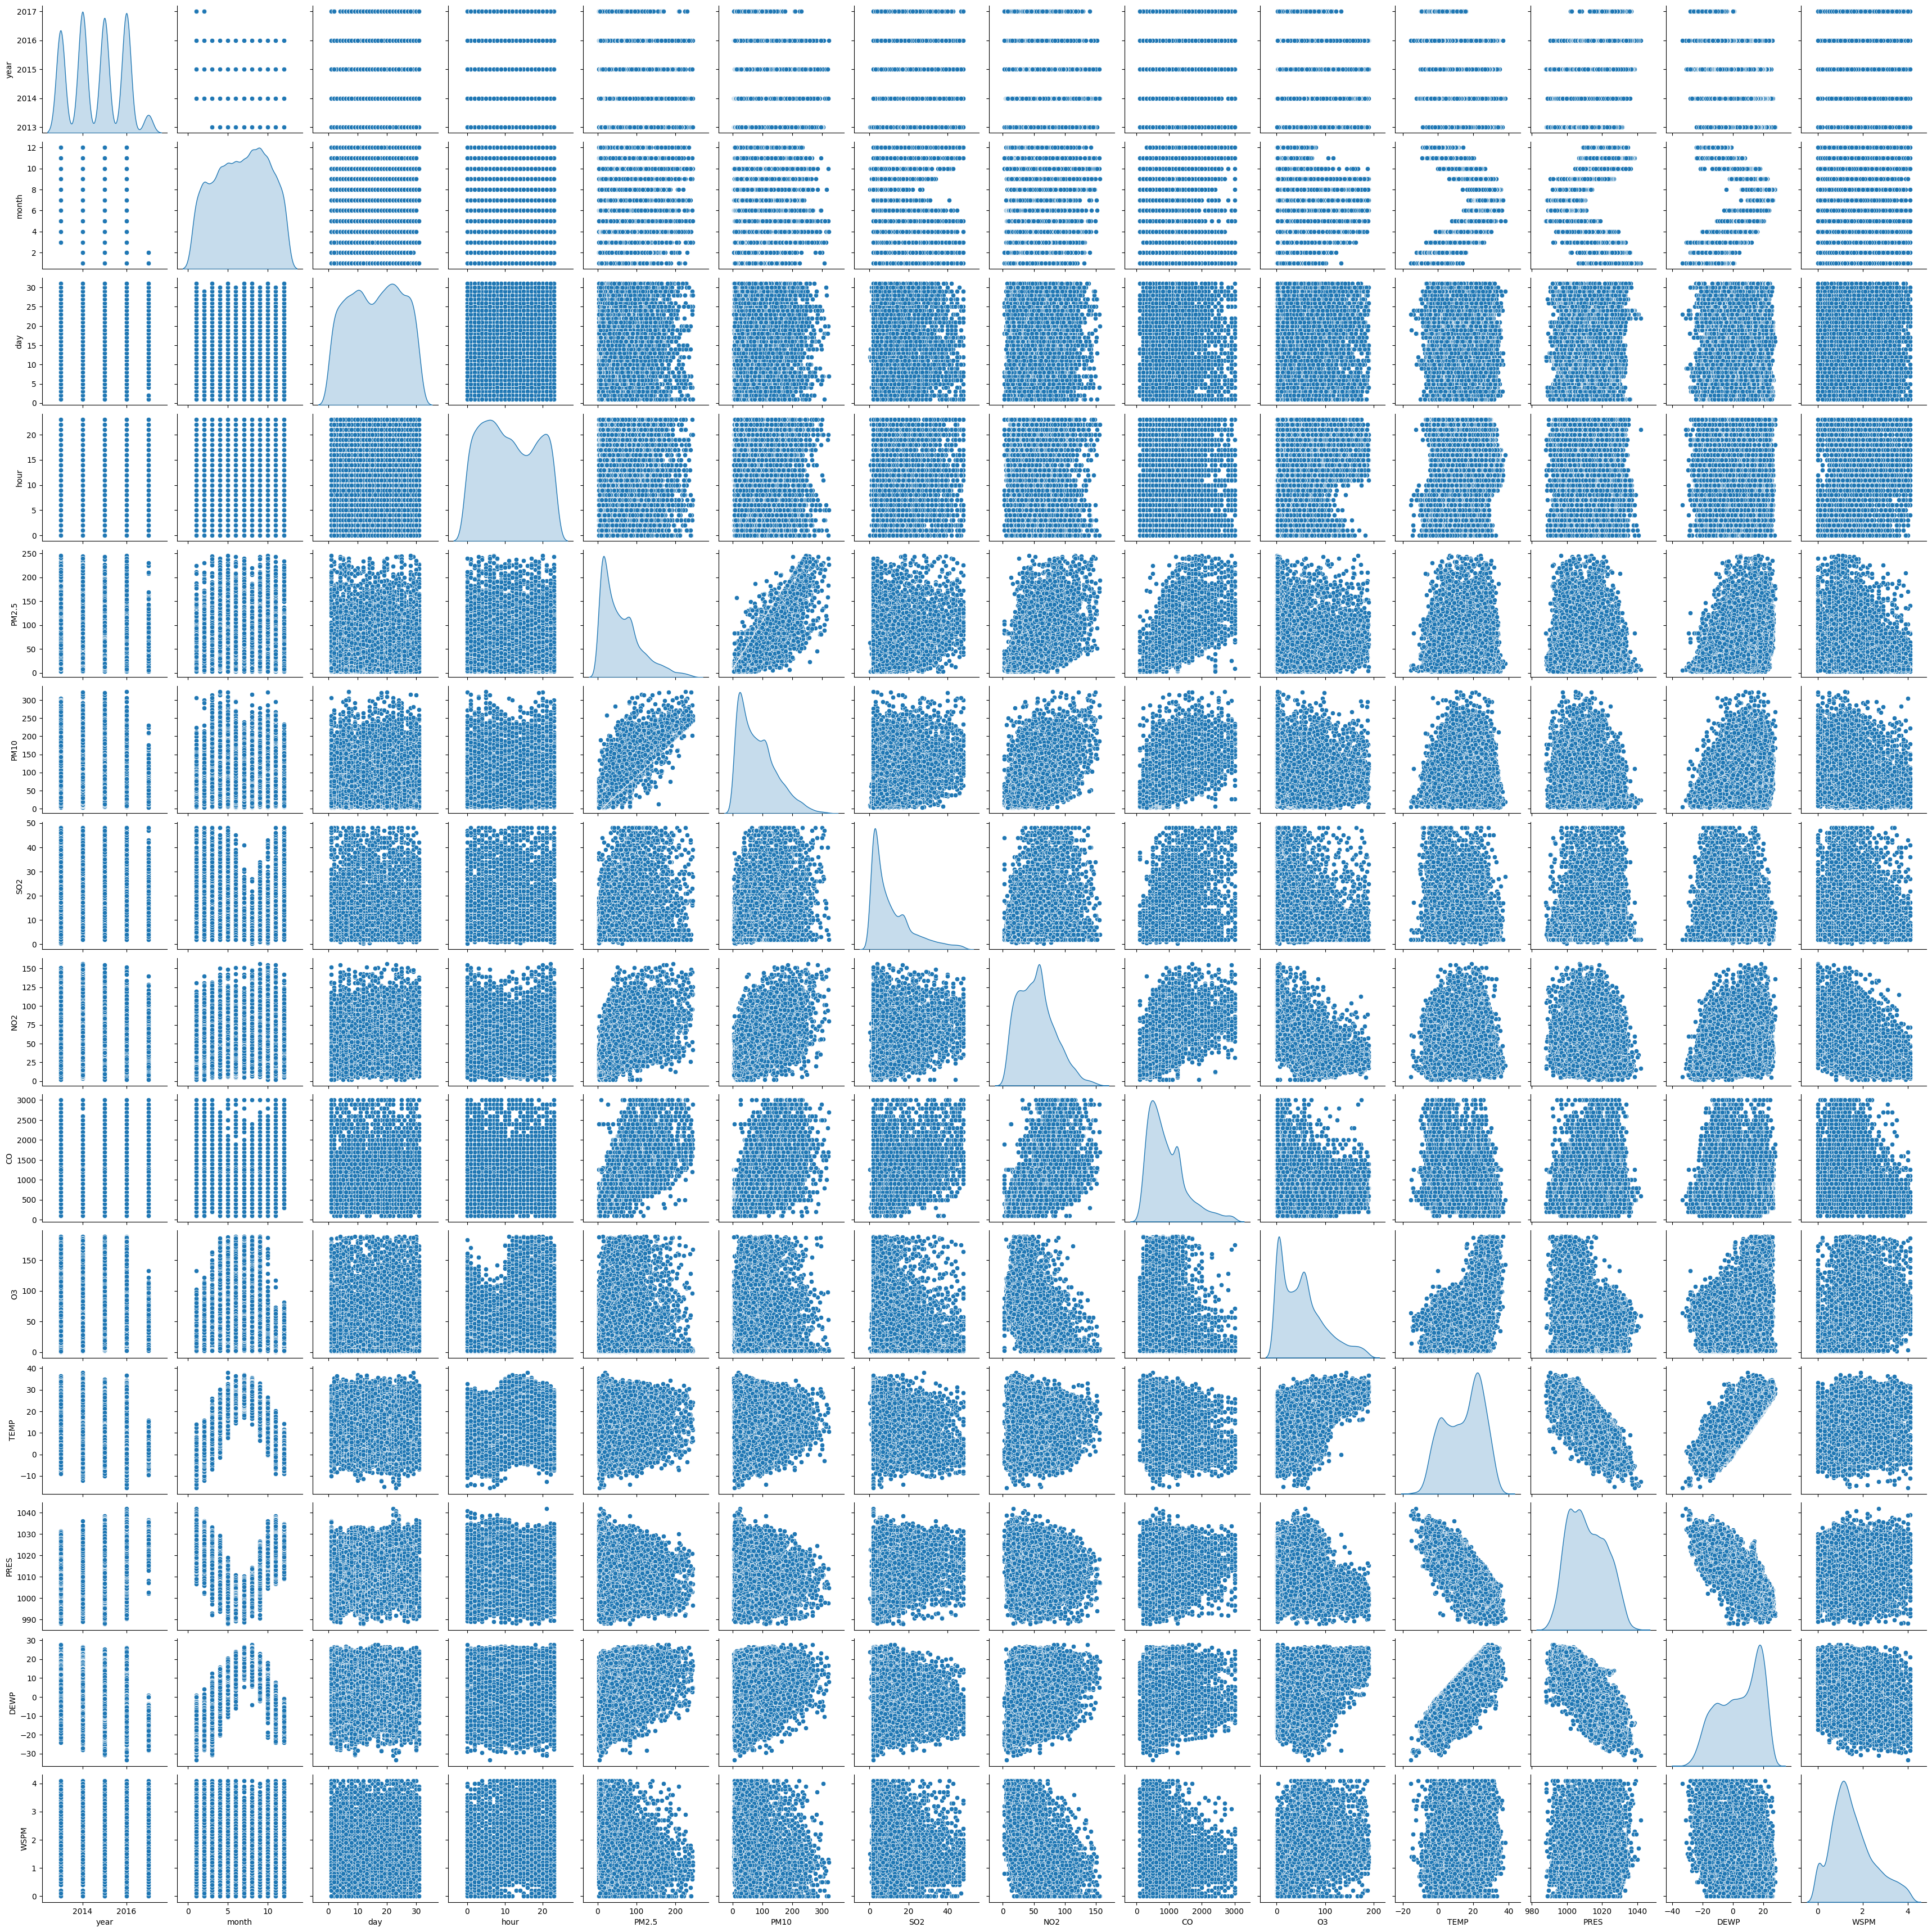

In [464]:
sns.pairplot(main_df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

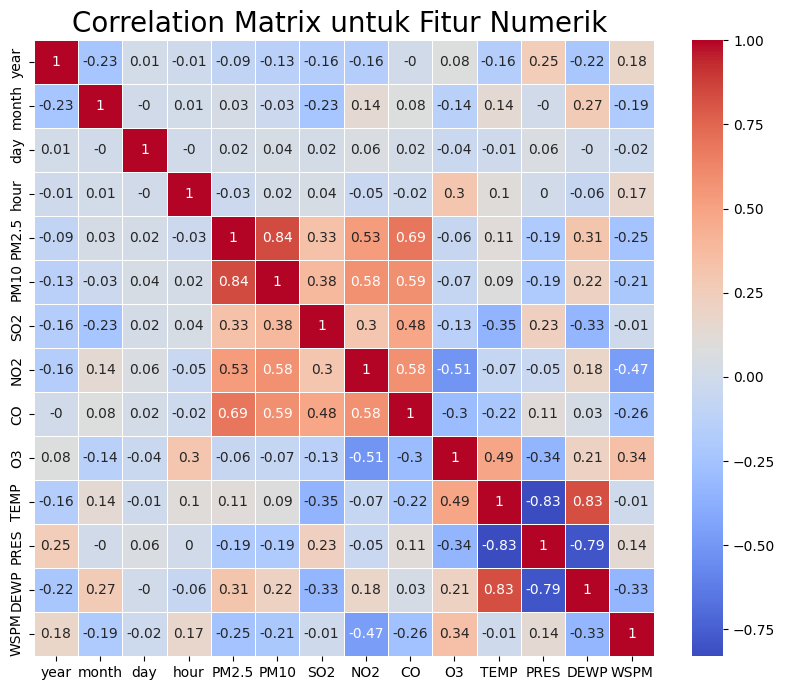

In [465]:
plt.figure(figsize=(10, 8))
correlation_matrix = main_df[num_cols].corr().round(2)
 
# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Dari hasil visualisasi korelasi antar fitur. Terlihat beberapa fitur memiliki berbagai macam nilai korelasi terhadap fitur PM2.5. Keputusan saat ini adalah melakukan drop untuk PM10 karena korelasi yang cukup tinggi dan mendrop O3 karena korelasi yang rendah.  
Lalu untuk fitur waktu (year, month, day, hour) tidak di drop karena dapat berisi informasi pola data. Dan fitur TEMP, PRES, dan DEWP , lalu fitur wd dan WSPM akan dilakukan feature engineering nantinya

In [466]:
main_df.drop(['PM10', 'O3'], inplace=True, axis=1)
main_df.head()

year  month  day  hour  PM2.5   SO2   NO2     CO  TEMP    PRES  DEWP   wd  \
1  2013      3    1     9    3.0  12.0  28.0  400.0   1.2  1028.5 -19.3    N   
2  2013      3    1    16    9.0   9.0  13.0  400.0   5.9  1025.6 -18.1  NNW   
3  2013      3    1    18   11.0   8.0  20.0  500.0   3.1  1027.4 -18.4  NNE   
4  2013      3    1    21   12.0  16.0  35.0  500.0   0.6  1030.1 -16.7  ENE   
5  2013      3    2     0   22.0  24.0  44.0  500.0  -0.4  1031.0 -17.6  ENE   

   WSPM  
1   2.6  
2   3.9  
3   2.1  
4   0.8  
5   1.4

## 3. Data Preparation

### Fitur Engineering

##### wd dan WSPM

In [467]:
direction_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}
main_df['wind_deg'] = main_df['wd'].map(direction_map)
main_df['wind_rad'] = np.deg2rad(main_df['wind_deg'])

main_df['wind_x'] = main_df['WSPM'] * np.cos(main_df['wind_rad'])
main_df['wind_y'] = main_df['WSPM'] * np.sin(main_df['wind_rad'])
main_df = main_df.drop(['wd', 'WSPM', 'wind_deg', 'wind_rad'], axis=1)

In [468]:
main_df.sample(5)

year  month  day  hour  PM2.5   SO2   NO2      CO  TEMP    PRES  DEWP  \
1302  2013      9    6    15   67.0  11.0  57.0  1100.0  25.6  1008.9  16.4   
9261  2016     11   13    10   69.0   5.0  68.0  2200.0   7.9  1014.9   3.7   
7461  2016      2   16    23   11.0  31.0  32.0   500.0   2.9  1022.0 -13.0   
2087  2013     12   27     2   15.0  19.0  40.0   600.0  -3.7  1027.8 -18.8   
2710  2014      3   30    18   29.0   6.0  47.0   400.0  22.4  1008.9  -1.7   

        wind_x    wind_y  
1302 -1.301124 -3.141190  
9261  0.267878  0.646716  
7461  2.400000  0.000000  
2087  1.400000  0.000000  
2710 -1.385819 -0.574025

Dilakukan penggabungan antara fitur wd dan WSPM, karena jika dilakukan Encoding fitur wd, dimana fitur wd memiliki banyak nilai unik, maka akan menghasilkan banyak kolom tambahan. Di sisi lain, fitur WSPM yang merupakan kecepatan angin dapat dikombinasikan dengan fitur ws untuk membuat komponen Vekto X dan Vektor Y yang merepresentasikan pergerakan 4 arah mata angin. Sehingga tidak perlu menambah banyak kolom baru

TEMP, PRES, DEWP dengan PCA

In [469]:
pca = PCA(n_components=3, random_state=123)
pca.fit(main_df[['TEMP', 'PRES', 'DEWP']])
princ_comp = pca.transform(main_df[['TEMP', 'PRES', 'DEWP']])
pca.explained_variance_ratio_.round(3)

array([0.88 , 0.074, 0.046])

Hasil penerapan PCA pada ketiga kolom menunjukan bahwa PC1 dan PC2 sudah cukup untuk mewakiliki data sebelumnya, sehingga hanya akan digunakan PCA dengan hasil 2 komponen

In [470]:
pca = PCA(n_components=2, random_state=123)
pca.fit(main_df[['TEMP', 'PRES', 'DEWP']])
princ_comp = pca.transform(main_df[['TEMP', 'PRES', 'DEWP']])
main_df[['components_1', 'components_2']] = princ_comp
main_df.drop(['TEMP', 'PRES', 'DEWP'], axis=1, inplace=True)
main_df.sample(5)

year  month  day  hour  PM2.5   SO2   NO2      CO        wind_x  \
705   2013      6   10     7   15.0   6.0  48.0   700.0 -1.285879e-16   
3192  2014      6    6     5   96.0   8.0  67.0  1000.0  6.888302e-01   
3633  2014      8   10    20   57.0   3.0  37.0   500.0 -1.836970e-16   
3644  2014      8   12    20   31.0   5.0  44.0   400.0 -0.000000e+00   
5441  2015      4   29     9  128.0  11.0  88.0  1600.0 -9.000000e-01   

            wind_y  components_1  components_2  
705  -7.000000e-01     11.363233      6.415562  
3192  1.662983e+00     21.052108     -0.436254  
3633 -1.000000e+00     26.284126     -0.508193  
3644  0.000000e+00     21.024681     -0.392706  
5441  1.102182e-16      8.757015      3.714110

### Data Splitting

In [471]:
X = main_df.drop(["PM2.5"],axis =1)
y = main_df["PM2.5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [472]:
print(f'Total sampel di seluruh dataset: {len(X)}')
print(f'Total sampel di train dataset: {len(X_train)}')
print(f'Total sampel di test dataset: {len(X_test)}')

Total sampel di seluruh dataset: 7536
Total sampel di train dataset: 6028
Total sampel di test dataset: 1508


Data dibagi menjadi data train dan data test dengan pembagian 80% train dan 20% test. Lalu hasilnya adalah 6028 baris data digunakan untuk data train dan 1508 digunakan untuk data test.

### Standarisasi 

In [473]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [474]:
X_train.describe().round(4)

year      month        day       hour        SO2        NO2  \
count  6028.0000  6028.0000  6028.0000  6028.0000  6028.0000  6028.0000   
mean   2014.6506     6.6923    15.9404    11.1413    11.1917    54.1039   
std       1.1773     3.2540     8.7637     7.0292    10.5317    28.8335   
min    2013.0000     1.0000     1.0000     0.0000     0.2856     2.0000   
25%    2014.0000     4.0000     8.0000     5.0000     3.0000    31.0000   
50%    2015.0000     7.0000    16.0000    11.0000     7.0000    53.0000   
75%    2016.0000     9.0000    23.0000    17.0000    17.0000    72.0000   
max    2017.0000    12.0000    31.0000    23.0000    48.0000   155.0000   

              CO     wind_x     wind_y  components_1  components_2  
count  6028.0000  6028.0000  6028.0000     6028.0000     6028.0000  
mean    930.0275     0.2176     0.0603       -0.0897        0.0579  
std     585.6795     1.3180     1.2221       19.2643        5.5852  
min     100.0000    -3.7879    -3.9000      -55.3296      -25.7502  
25%     500.0000    -0.6467    -0.7391      -16.8906       -3.2596  
50%     800.0000     0.0707     0.0707        3.0278        0.5573  
75%    1258.0659     0.9899     0.9192       17.2103        3.8892  
max    3000.0000     4.1000     3.7879       34.4312       16.1063

Hasil standarisasi menunjukan bahwa keseluruhan data sudah memiliki rata rata 0 dan standar deviasi sangat mendekati 1

## 4. Modeling

In [475]:
models = pd.DataFrame(index=['train_mse', 'test_mse', 'train_mae', 'test_mae'], 
                      columns=['Random Forest', 'SVM', 'KNN'])

### Random Forest

In [476]:
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(X_train_scaled, y_train)
models.loc['train_mse', 'Random Forest'] = mean_squared_error(y_true=y_train, y_pred=RF.predict(X_train_scaled))
models.loc['train_mae', 'Random Forest'] = mean_absolute_error(y_true=y_train, y_pred=RF.predict(X_train_scaled))

Pertama digunakan algoritma random forest, algoritma ini digunakan karena cukup mampu menangkap hubungan non-linear pada data, dan juga merupakan model ensemble yaitu model yang menggabungkan beberapa model sederhana sehingga diharapakan dapat menghasilkan nilai prediksi yang akurat

### SVM

In [477]:
SVM = SVR(kernel='rbf')
SVM.fit(X_train_scaled, y_train)
models.loc['train_mse', 'SVM'] = mean_squared_error(y_true=y_train, y_pred=SVM.predict(X_train_scaled))
models.loc['train_mae', 'SVM'] = mean_absolute_error(y_true=y_train, y_pred=SVM.predict(X_train_scaled))

Algoritma yang kedua digunakan adalah algoritma SVM. Algoritma SVM cukup efektif dalam menangkap pola yang cenderung rumit dari data. Lalu jika dapat mengoptimalkan hyperparameter yang digunakan maka hasil yang baik bisa didapatkan

### KNN

In [478]:
KNN = KNeighborsRegressor(n_neighbors=10)
KNN.fit(X_train_scaled, y_train)
models.loc['train_mse', 'KNN'] = mean_squared_error(y_true=y_train, y_pred=KNN.predict(X_train_scaled))
models.loc['train_mae', 'KNN'] = mean_absolute_error(y_true=y_train, y_pred=KNN.predict(X_train_scaled))

Terakhir adalah menggunakan algoritma KNN. Algoritma ini merupakann algoritma yang cukup sederhana dan mudah dipahami. Sehingga tidak rumit untuk melakukan interpretasi

## Model Evaluation

Evaluasi model menggunakan Mean Squared Error atau MSE dan Mean Absolute Error atau MAE. MAE memberikan rata rata nilai absolut selisih antara nilai aktual dan prediksi, sedangkan MSE akan melakukan rata rata dari selisih yang dikuadratkan antara nilai aktual dan nilai prediksi, jadi MSE memiliki bobot yang jauh lebih besar terhadap kesalahan yang besar

In [479]:
mse = pd.DataFrame(columns=['mse_train', 'mse_test'], index=['RF', 'SVM', 'KNN'])
mae = pd.DataFrame(columns=['mae_train', 'mae_test'], index=['RF', 'SVM', 'KNN'])
model_dict = {'RF': RF, 'SVM': SVM, 'KNN': KNN}
for name, model in model_dict.items():
    mse.loc[name, 'mse_train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mse.loc[name, 'mse_test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3
    mae.loc[name, 'mae_train'] = mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mae.loc[name, 'mae_test'] = mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test))/1e3


c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\u

In [480]:
mse

mse_train   mse_test
RF   13.735435  13.679529
SVM   2.642075   2.545955
KNN   7.896921   7.842159

In [481]:
mae

mae_train  mae_test
RF   0.108756  0.108714
SVM  0.039015  0.038151
KNN  0.080836   0.08057

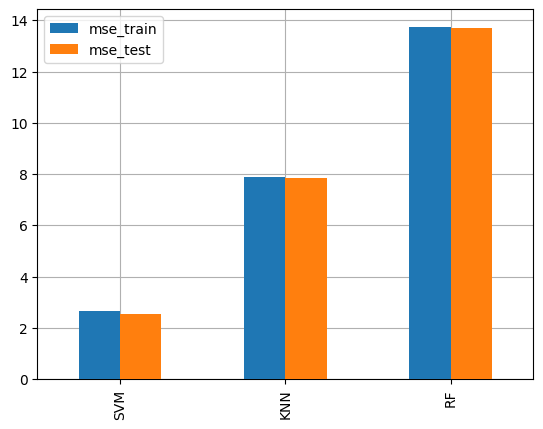

In [482]:
fig, ax = plt.subplots()
mse.sort_values(by='mse_test', ascending=True).plot(kind='bar', ax=ax, zorder=3)
ax.grid(zorder=0)

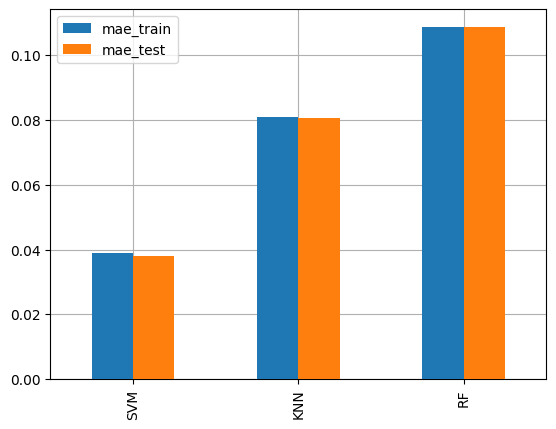

In [483]:
fig, ax = plt.subplots()
mae.sort_values(by='mae_test', ascending=True).plot(kind='bar', ax=ax, zorder=3)
ax.grid(zorder=0)

Hasil evaluasi model terhadap data test dilihat dari visualisasinya menunjukan bahwa model yang memiliki nilai MSE dan MAE terendah adalah model SVM. Yaitu dengan nilai MSE = 2,54 dan nilai MAE = 0,038. 

In [484]:
prediksi = X_test.iloc[10:11].copy()
pred_dict = {'y_true':y_test[:1]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
pd.DataFrame(pred_dict)

c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Proyek Machine Learning Terapan\Proyek Pertama\proyek-pertama\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


y_true  prediksi_RF  prediksi_SVM  prediksi_KNN
8871    42.0        182.6          49.2         132.6

Dilihat dari inferensi singkat ketiga model di atas pun menunjukan bahwa model SVM dapat melakukan prediksi yang paling baik. Yaitu ketika nilai aktualnya adalah 42.0, nilai prediksi yang paling mendekati adalah nilai prediksi dari SVM yaitu 49.2